In [7]:
%pylab inline
import numpy as np
from sklearn import gaussian_process
from sklearn import metrics

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [8]:
def f(x):
    return -x[0]*x[0] - x[1]*x[1]
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T
y = f(X).ravel()
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

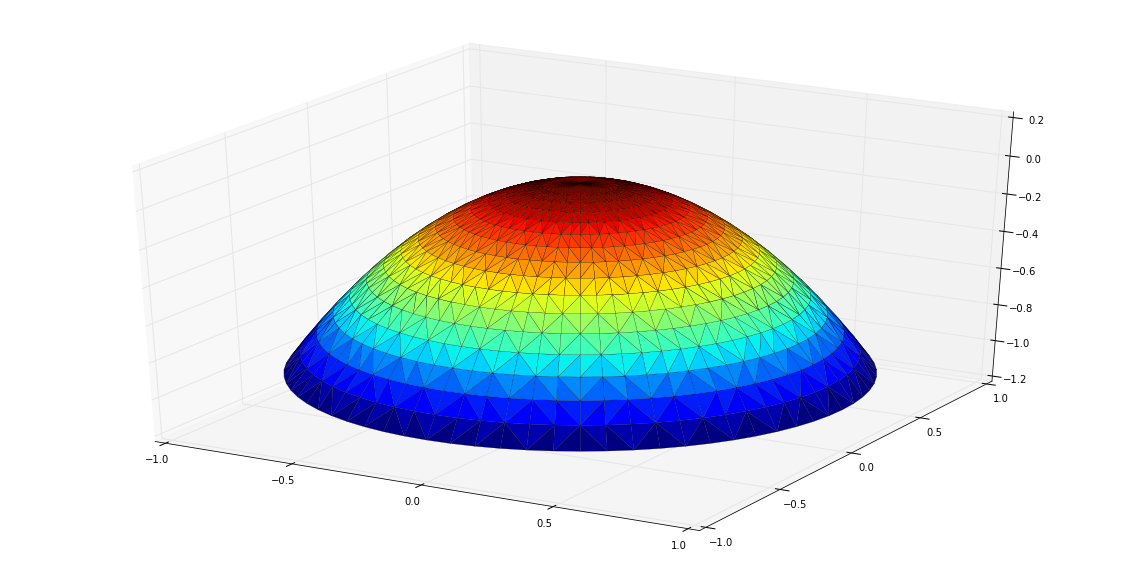

In [9]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

n_angles = 72
n_radii = 16

# An array of radii
# Does not include radius r=0, this is to eliminate duplicate points
radii = np.linspace(0.125, 1.0, n_radii)

# An array of angles
angles = np.linspace(0, 2*np.pi, n_angles, endpoint=False)

# Repeat all angles for each radius
angles = np.repeat(angles[..., np.newaxis], n_radii, axis=1)

# Convert polar (radii, angles) coords to cartesian (x, y) coords
# (0, 0) is added here. There are no duplicate points in the (x, y) plane
x = np.append(0, (radii*np.cos(angles)).flatten())
y = np.append(0, (radii*np.sin(angles)).flatten())

# Pringle surface
z = -x*x - y*y

fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')

ax.plot_trisurf(x, y, z, cmap=cm.jet, linewidth=0.2)

plt.savefig('1.png')
plt.show()


In [10]:
radii=rand(100)
angles=2*pi*rand(100)
xs = (radii*np.cos(angles)).flatten()
ys = (radii*np.sin(angles)).flatten()

# Pringle surface
zs = -xs*xs - ys*ys

xstest, xstrain = xs[:20], xs[20:]
ystest, ystrain = ys[:20], ys[20:]
zstest, zstrain = zs[:20], zs[20:]

test = vstack((xstest,ystest)).T
train = vstack((xstrain,ystrain)).T

errs = []
X=train[:30]
y=zstrain[:30]
for i in range(30,80):
    if i == 0:
        X=train[i]
        y=zstrain[i]
    else:
        X = vstack((X, train[i]))
        y = hstack((y,zstrain[i]))
    gp = gaussian_process.GaussianProcess(theta0=1e-2, thetaL=1e-4, thetaU=1e-1)
    gp.fit(X, y)
    y_pred, sigma2_pred = gp.predict(test, eval_MSE=True)
    errs = append(errs,metrics.mean_squared_error(y_pred, zstest))
    
def argminn(train, new):
    min_err=100
    argmin=[0,0]
    for i in range(train.shape[0]):
        err = sqrt((train[i][0]-new[0])**2+(train[i][0]-new[1])**2)
        if min_err > err:
            min_err = err
            argmin = train[i]
    return min_err

def argmin(train, y, test, y_test):
    y_argmin = 0
    argmin=[0,0]
    min_dist = -1
    min_index=0
    for i in range(test.shape[0]):
        dist = argminn(train,test[i])
        if min_dist < dist:
            min_dist=dist
            argmin=test[i]
            y_argmin=y_test[i]
            min_index=i
    test = numpy.delete(test, (min_index), axis=0)
    y_test = numpy.delete(y_test, (min_index), axis=0)
    return test, y_test, argmin, y_argmin

errs1 = []
X=train[:30]
y=zstrain[:30]
X_test = train[30:]
y_test = zstrain[30:]
for i in range(50):
    X_test, y_test, arg_min, y_argmin = argmin(X, y, X_test, y_test)
    X = vstack((X, arg_min))
    y = hstack((y, y_argmin))
    gp = gaussian_process.GaussianProcess(theta0=1e-2, thetaL=1e-4, thetaU=1e-1)
    gp.fit(X, y)
    y_pred, sigma2_pred = gp.predict(test, eval_MSE=True)
    errs1 = append(errs1,metrics.mean_squared_error(y_pred, zstest))
    
def argz(train, y, test, y_test):
    y_argmin = 0
    argmin=[0,0]
    min_dist = -1
    min_index=0
    for i in range(test.shape[0]):
        gp = gaussian_process.GaussianProcess(theta0=1e-2, thetaL=1e-4, thetaU=1e-1)
        gp.fit(train, y)
        y_pred, dist = gp.predict(test[i], eval_MSE=True)
        if min_dist < dist:
            min_dist=dist
            argmin=test[i]
            y_argmin=y_test[i]
            min_index=i
    test = numpy.delete(test, (min_index), axis=0)
    y_test = numpy.delete(y_test, (min_index), axis=0)
    return test, y_test, argmin, y_argmin

errs2 = []
X=train[:30]
y=zstrain[:30]
X_test = train[30:]
y_test = zstrain[30:]
for i in range(50):
    X_test, y_test, arg_min, y_argmin = argz(X, y, X_test, y_test)
    X = vstack((X, arg_min))
    y = hstack((y, y_argmin))
    gp = gaussian_process.GaussianProcess(theta0=1e-2, thetaL=1e-4, thetaU=1e-1)
    gp.fit(X, y)
    y_pred, sigma2_pred = gp.predict(test, eval_MSE=True)
    errs2 = append(errs2,metrics.mean_squared_error(y_pred, zstest))

def argx(train, y, test, y_test, valid, y_valid):
    y_argmin = 0
    argmin=[0,0]
    min_dist = 1000
    min_index=0
    for i in range(test.shape[0]):
        gp = gaussian_process.GaussianProcess(theta0=1e-2, thetaL=1e-4, thetaU=1e-1)
        gp.fit(vstack((train, test[i])), hstack((y, y_test[i])))
        y_pred, _ = gp.predict(valid, eval_MSE=True)
        dist = metrics.mean_squared_error(y_pred, y_valid)
        if min_dist > dist:
            min_dist=dist
            argmin=test[i]
            y_argmin=y_test[i]
            min_index=i
    test = numpy.delete(test, (min_index), axis=0)
    y_test = numpy.delete(y_test, (min_index), axis=0)
    return test, y_test, argmin, y_argmin

errs3 = []
X=train[:30]
y=zstrain[:30]
X_test = train[30:]
y_test = zstrain[30:]
for i in range(50):
    X_test, y_test, arg_min, y_argmin = argx(X, y, X_test, y_test,test,zstest)
    X = vstack((X, arg_min))
    y = hstack((y, y_argmin))
    gp = gaussian_process.GaussianProcess(theta0=1e-2, thetaL=1e-4, thetaU=1e-1)
    gp.fit(X, y)
    y_pred, sigma2_pred = gp.predict(test, eval_MSE=True)
    errs3 = append(errs3,metrics.mean_squared_error(y_pred, zstest))

/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GaussianProcess is deprecated; GaussianProcess is deprecated and will be removed in 0.20. Use the GaussianProcessRegressor instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function l1_cross_distances is deprecated; l1_cross_distances is deprecated and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GaussianProcess is deprecated; GaussianProcess is deprecated and will be removed in 0.20. Use the GaussianProcessRegressor instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function l1_cross_distances is deprecated; l1_cross_distances is deprecated and will be removed in 0.

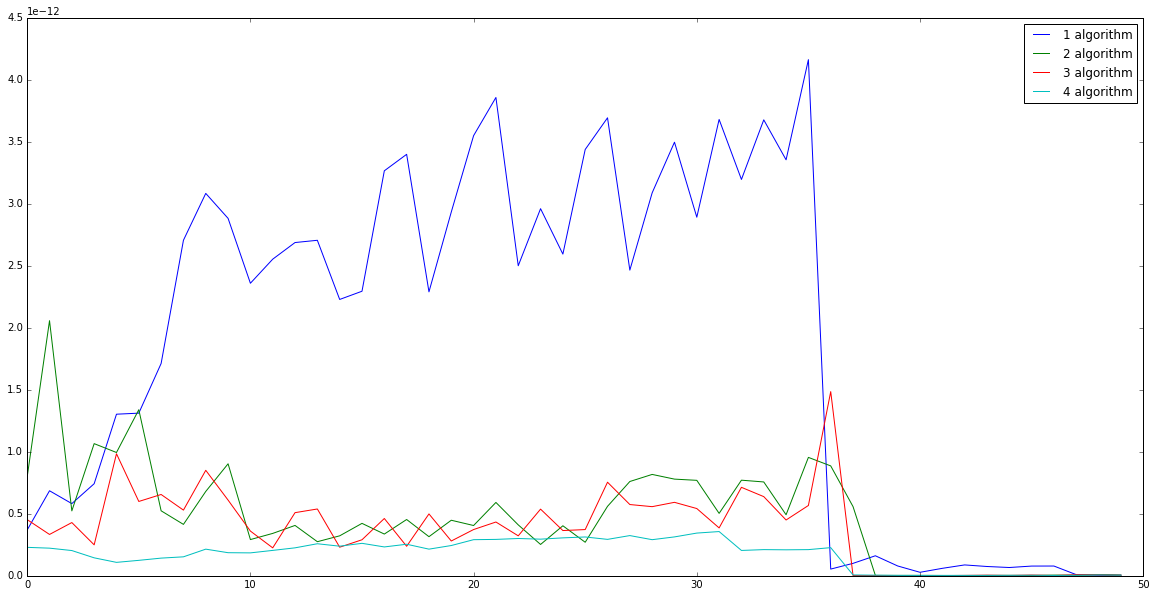

In [11]:
plt.figure(figsize=(20,10))
plot(range(50), errs,label='1 algorithm')
plot(range(50), errs1,label='2 algorithm')
plot(range(50), errs2,label='3 algorithm')
plot(range(50), errs3,label='4 algorithm')
plt.legend()
plt.savefig('4.png')